# 线性神经网络

### 线性回归by hand
#### 理论
数学模型:
$$
\hat y = \mathbf w^T\mathbf x
$$
回归问题一般选MSE做损失函数：
$$
L(\mathbf w,b) = \frac 1 n\sum_{i=1}^n \frac 1 2 \big(\mathbf w^T\mathbf x +b-y^{(i)}\big)^2
$$
目标：
$$
\mathbf w^{best},b^{best} = \operatorname*\argmin _{\mathbf w,b} L(\mathbf w,b)
$$


另：一条重要结论  
在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。证明过程：  
于假设显性模型的输出中增加了高斯噪声
$$y=\mathbf w^T\mathbf x + b + \epsilon, 其中 \epsilon \sim \mathcal N(0,\sigma^2) $$
因此可以写出给定x观测到y的似然：
$$P(y|\mathbf x) = \frac 1 {\sqrt {2\pi}\sigma}exp\Big(-\frac {1} {2\sigma^2} (y - \mathbf w^T\mathbf x - b) \Big)$$
然后根据极大似然估计: **模型参数的最优值是使整个数据集的似然最大的值**。整个数据集都发生的似然为（样本集满足i.i.d假设情况下）：
$$
\mathbf w^{best},b^{best}=\argmax_{\mathbf w,b} p(\mathbf y | \mathbf X) = \argmax_{\mathbf w,b}\prod_{i=1}^{n}p(y^{(i)}|\mathbf x^{(i)})
 $$
对目标函数p(y|X)取负对数得到损失函数：
$$
-\log  p(\mathbf y | \mathbf X) = \sum_{i=1}^n \frac 1 2 \log (2\pi \sigma^2) + \frac 1 {2\sigma^2}\Big( y^{(i)} - \mathbf w^T\mathbf x^{(i)} - b\Big)^2
$$
最后一个式子即等价于均方误差MSE


使用设备类型: mps
前5个特征: tensor([[-0.6267, -0.2394],
        [-0.1650,  0.2061],
        [-0.7974,  0.0739],
        [ 0.2181,  1.6163],
        [-1.3199,  0.9532]], device='mps:0'), 
前5个标签:tensor([[ 3.7538],
        [ 3.1646],
        [ 2.3587],
        [-0.8509],
        [-1.6771]], device='mps:0')
形状:feature[1000, 2], labeltorch.Size([1000, 1])


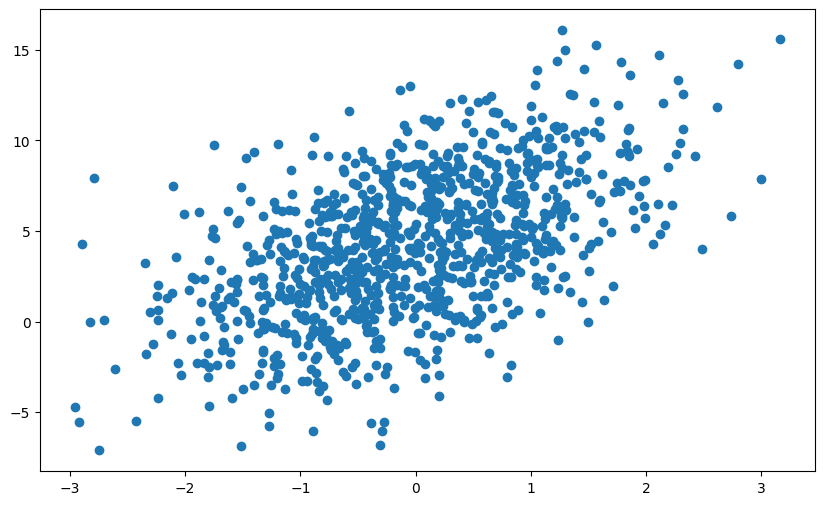

In [91]:
%matplotlib inline
import torch
import math
import numpy as np
import time

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'使用设备类型: {device}')
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return torch.cumsum(torch.tensor(self.times),-1).tolist()

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)),device=device)
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape,device=device)
    return X, y[..., None] ## 为啥要升维？

true_w = torch.tensor([2, -3.4],dtype=torch.float32,device=device)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(f'前5个特征: {features[:5]}, \n前5个标签:{labels[:5]}\n形状:feature{list(features.shape)}, label{labels.shape}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# 散点图的x和y的shape要一致，因此要features, labels)会报错
x = features[:, 0].squeeze() # 这里不 squeeze 也可以，因为 scatter 会自动处理 1 维张量
y = labels.squeeze()
plt.scatter(x.cpu(), y.cpu())
plt.show()

In [92]:
import random

# 训练相关准备
# 随机迭代
def data_iter(batch_size, features, labels):
    num = len(features)
    indices = list(range(num))
    random.shuffle(indices)
    for i in range (0,num,batch_size):
        batch_indices = indices[i:min(i+batch_size,num)]
        yield features[batch_indices],labels[batch_indices]
# 初始化模型参数
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
w = torch.normal(0,0.01,(2,1),requires_grad=True,device=device)
b = torch.zeros(1,requires_grad=True,device=device)

# 模型输出函数
def line_regression(X:torch.Tensor,w:torch.Tensor,b:torch.Tensor):
    return X.matmul(w) + b
# 损失函数
def mse_loss(y:torch.Tensor,y_hat:torch.Tensor):
    return ((y.squeeze() - y_hat.squeeze())**2)/2
# 优化方法，注意这里为什么要除以batch_size?
def sgd(params:list[torch.Tensor], lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size
            param.grad.zero_() ## 注意这里要清零




tensor([[-0.5612, -0.8745],
        [-0.0461, -0.1930],
        [ 1.4793, -0.6000],
        [ 0.2183, -0.8328],
        [ 0.2394,  1.1174],
        [-0.6097, -0.6409],
        [ 0.3754, -1.1416],
        [ 1.2245, -1.1578],
        [ 0.8412, -0.4681],
        [-0.1921,  0.2356]], device='mps:0') 
 tensor([[ 6.0479],
        [ 4.7699],
        [ 9.1938],
        [ 7.4495],
        [ 0.8787],
        [ 5.1699],
        [ 8.8292],
        [10.5939],
        [ 7.4584],
        [ 2.9946]], device='mps:0')


In [93]:
# 开始训练
lr = 0.03
epoch_num = 5
net = line_regression
loss = mse_loss

for epoch_idx in range(epoch_num):
    for X,y in data_iter(batch_size,features,labels):
        y_hat = net(X,w,b)
        l = loss(y,y_hat)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(labels,net(features,w,b))
        print(f'epoch{epoch_idx+1}, mean loss {float(train_l.mean()):.5f}')
print(f'finshed train, ground truth w:{true_w.tolist()},b:{true_b}\nour model param w:{w.tolist()},b:{b.tolist()}')

epoch1, mean loss 0.03351
epoch2, mean loss 0.00012
epoch3, mean loss 0.00005
epoch4, mean loss 0.00005
epoch5, mean loss 0.00005
finshed train, ground truth w:[2.0, -3.4000000953674316],b:4.2
our model param w:[[2.0007412433624268], [-3.4007723331451416]],b:[4.2001471519470215]


### 总结一下
先说一个误区：MSE的计算公式是包含求平均这个操作的
$$
MSE = \frac 1 n \sum_{i=1}^n (y^{(i)} - \hat y^{(i)})
$$
但是李沐的代码里，mse计算的时候并没有计算这个1/n的平均，但是在sgd里减梯度的时候除以了一个batch_size

模型训练三要素：
- net：模型本身，其实是一个将输入的批量样本映射成一个输出的映射函数，它的参数包含**批量输入的特征X、模型参数（包含w，b）**
- loss：损失函数，只负责将模型输出的估计值和真实的样本标签（两个都是批量的）映射为一个损失值（也是批量），它的输入只有**估计值和真实标签**
- 优化函数：主要负责对模型本身进行参数更新

每个batch的处理流程：
1. 批量特征数据输入模型，得到批量估计输出
2. 根据估计输出和标签计算loss（loss也是批量的）
3. loss.sum().backword()，此时梯度会存储在模型的各个参数
4. 使用优化器更新模型参数，优化器内部会读取模型的梯度，自动更新。注意优化器在更新模型参数时要with torch.no_grad()，更新完成后要net.grad.zero_()清除本次的梯度，否则会累积

### 线性回归by nn

In [97]:
from torch.utils import data
from torch import nn

true_w = torch.tensor([7,-3.45,3.767,667.32,5.2,-1136.22,0.32],dtype=torch.float32,device=device)
true_b = torch.tensor(12.76,dtype=torch.float32,device=device)
n = 10000
features,labels = synthetic_data(true_w,true_b,n)
print(f'前5个特征: {features[:5]}\n前5个标签: {labels[:5]}\n形状 feature:{features.shape}, labels:{labels.shape}')

batch_size = 10
data_iter = data.DataLoader(data.TensorDataset(features,labels),batch_size,True)
net = nn.Sequential(nn.Linear(7,1,device=device))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

print(f'原始w:\t\t{true_w.tolist()}, b:{true_b.tolist()}')
print(f'训练结束后w:\t{net[0].weight.data.squeeze().tolist()}, b:{net[0].bias.data.squeeze().tolist()}')
    

前5个特征: tensor([[ 0.5881,  0.5314,  1.3957, -1.7459, -0.2199,  0.0474, -1.4854],
        [-2.1224,  0.7194, -0.7836,  0.7008, -1.1378, -0.3142,  0.1536],
        [ 0.1314, -1.8175,  0.1324,  0.4120,  0.4054,  2.0305,  0.4762],
        [ 0.4216, -0.3896, -0.1684,  1.3252, -0.8261, -0.2304,  1.3820],
        [-0.5031, -0.4521,  0.0295, -1.4928, -0.8894,  1.7446, -0.3582]],
       device='mps:0')
前5个标签: tensor([[-1200.2207],
        [  811.2950],
        [-2009.4478],
        [ 1158.6775],
        [-2972.2432]], device='mps:0')
形状 feature:torch.Size([10000, 7]), labels:torch.Size([10000, 1])
epoch 1, loss 0.000100
epoch 2, loss 0.000102
epoch 3, loss 0.000103
原始w:		[7.0, -3.450000047683716, 3.7669999599456787, 667.3200073242188, 5.199999809265137, -1136.219970703125, 0.3199999928474426], b:12.760000228881836
训练结束后w:	[6.999239921569824, -3.449265241622925, 3.7679200172424316, 667.320556640625, 5.19965124130249, -1136.2196044921875, 0.3198120594024658], b:12.760114669799805


总结一下：

1. 使用torch.utils包下的data.TensorDataset和data.DataLoader实现数据的乱序批量读取
2. 使用torch.optim.SGD优化器时，需要传入全部的模型参数，对于nn下的模型，直接使用xx.parameters()即可返回。注意parameters()方法会返回所有模型的参数
3. 使用nn.Sequential和nn.Linear组合实现模型层，nn下的模型都默认requires_grad=True
4. 使用nn.MSELoss()计算损失，注意这个返回的是平均的损失了，是一个标量
5. backward之前，一定要记得trainer.zero_grad()
6. backward
7. trainer.step()

> 实现的时候踩了一个坑，在生成数据的时候，true_w和true_b都使用了requires_grad=True，导致生成的features, labels都带梯度了，训练的时候报错

另，做一个实验看一下nn.Sequential和nn.Linear的参数构成，可以看到，Sequential的参数即全部参数的累加，线性层的参数有一个矩阵和偏执，矩阵的参数的0,1维分别为输出和输入


In [101]:
a = nn.Sequential(
    nn.Linear(10,256),
    nn.ReLU(),
    nn.Linear(256,1024),
    nn.ReLU(),
    nn.Linear(1024,10)
    )
b = list(a.parameters())
len(b)
for p in b: 
    print(p.shape)

torch.Size([256, 10])
torch.Size([256])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


### softmax by hand
#### 理论
从网络结构上，softmax本质上是多输出的线性层，然后在输出层做一次softmax归一化。softmax回归用于做分类。分类问题一般选择交叉熵做损失函数
$$
softmax = \frac {\exp(x^i)} {\sum_{j=0}^n \exp(x^j)}
$$
尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。 因此，softmax回归是一个线性模型（linear model）。

负对数似然
$$
-\log P(\mathbf Y|\mathbf X) = \sum_{i=0}^n-\log P(\mathbf y^{(i)}|\mathbf x^{(i)})
$$
由于y^i是one-hot编码，所以上式等于
$$
-\log P(\mathbf Y|\mathbf X) = \sum_{i=0}^n-\log P(\mathbf y^{(i)}|\mathbf x^{(i)})
$$
